In [2]:
!pip install scikit-image

In [3]:
import numpy as np

csv_path = "C:/Users/rvshi/OneDrive/Documents/adobe/problems/problems/isolated.csv"
def read_csv(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=',')
    path_XYs = []
    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = []
        for j in np.unique(npXYs[:, 0]):
            XY = npXYs[npXYs[:, 0] == j][:, 1:]
            XYs.append(XY)
        path_XYs.append(XYs)
    return path_XYs


In [4]:
path_XYs = read_csv(csv_path)

In [5]:
colours = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

In [6]:
import matplotlib.pyplot as plt
def plot(path_XYs ):
    fig, ax = plt.subplots(tight_layout=True , figsize =(8, 8))
    for i, XYs in enumerate(path_XYs ):
        c = colours[i % len(colours)]
        for XY in XYs:
            ax.plot(XY[:, 0], XY[:, 1], c=c, linewidth =2)
    ax.set_aspect('equal')
    plt.show()

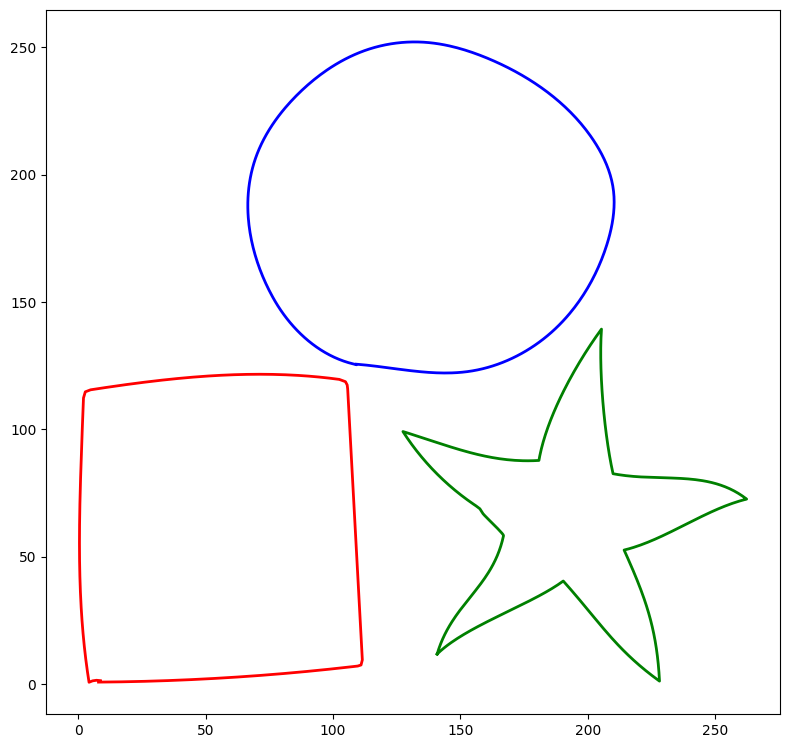

In [7]:
plot(path_XYs)

In [8]:
def line_intersection(line1, line2):
    """
    Find the intersection point of two lines given by endpoints.
    """
    x1, y1, x2, y2 = line1
    x3, y3, x4, y4 = line2
    
    denom = (x1-x2)*(y3-y4) - (y1-y2)*(x3-x4)
    if denom == 0:
        return None  # Lines are parallel
    
    intersect_x = ((x1*y2 - y1*x2)*(x3-x4) - (x1-x2)*(x3*y4 - y3*x4)) / denom
    intersect_y = ((x1*y2 - y1*x2)*(y3-y4) - (y1-y2)*(x3*y4 - y3*x4)) / denom
    
    return np.array([intersect_x, intersect_y])

In [15]:
from scipy.spatial import ConvexHull
import numpy as np

def is_straight_line(XY):
    # Check if points are collinear
    if len(XY) < 2:
        return False
    diffs = np.diff(XY, axis=0)
    return np.all(np.abs(diffs - diffs[0]) < 1e-5)

def is_circle(XY, tolerance=10):
    # Check if points lie on a circle
    if len(XY) < 3:
        return False
    center = np.mean(XY, axis=0)
    radius = np.linalg.norm(XY[0] - center)
    distances = np.linalg.norm(XY - center, axis=1)
    return np.all(np.isclose(distances, distances[0], atol=tolerance))

def is_ellipse(XY):
    # Use an ellipse fitting algorithm to determine if the shape is an ellipse
    from skimage.measure import EllipseModel
    if len(XY) < 5:
        return False
    try:
        ellipse = EllipseModel()
        ellipse.estimate(XY)
        return True
    except:
        return False
import cv2
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
def is_rectangle(XY, threshold=50, min_line_length=50, max_line_gap=10, angle_tolerance=15, distance_tolerance=10):
    """
    Detects if the shape defined by XY coordinates is a rectangle using the Hough Line Transform.
    Handles imperfections such as tilt and slight noise.
    """
    # Step 1: Create a binary image from the point cloud
    img_size = (256, 256)
    img = np.zeros(img_size, dtype=np.uint8)
    
    # Normalize points to fit the image, making sure they don't exceed the image size
    XY = (XY * ((img_size[0] - 1) / XY.max(axis=0))).astype(int)
    
    img[XY[:, 1], XY[:, 0]] = 255

    # Step 2: Use Canny edge detection
    edges = cv2.Canny(img, 50, 150, apertureSize=3)

    # Step 3: Apply Hough Line Transform
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold, minLineLength=min_line_length, maxLineGap=max_line_gap)

    if lines is None:
        return False  # No lines detected

    # Step 4: Cluster lines by angle
    angles = []
    for line in lines:
        x1, y1, x2, y2 = line[0]
        angle = np.degrees(np.arctan2(y2 - y1, x2 - x1))
        angles.append(angle)
    
    angles = np.array(angles).reshape(-1, 1)
    db = DBSCAN(eps=angle_tolerance, min_samples=1).fit(angles)
    
    unique_labels = np.unique(db.labels_)
    
    
    
    # Step 5: Check if grouped lines are approximately perpendicular
    group1 = angles[db.labels_ == unique_labels[0]]
    group2 = angles[db.labels_ == unique_labels[1]]
    
    angle_diff = abs(np.mean(group1) - np.mean(group2))
    
    if not np.isclose(angle_diff, 90, atol=angle_tolerance):
        return False
    
    # Step 6: Ensure that the lines form a closed shape (a rectangle)
    # Find intersections of lines to determine the corners of the rectangle
    
    points = []
    for i in range(len(lines)):
        for j in range(i+1, len(lines)):
            intersection = line_intersection(lines[i][0], lines[j][0])
            if intersection is not None:
                points.append(intersection)
    
    

    # Step 7: Apply PCA to further check if the points are aligned as a rectangle
    pca = PCA(n_components=2)
    pca.fit(points)
    
    if not np.isclose(abs(pca.explained_variance_ratio_[0] - pca.explained_variance_ratio_[1]), 0, atol=1):
        
        return False  # The points are not aligned in a rectangular manner
    
    return True

def is_rounded_rectangle(XY):
    # Check for rectangles with rounded corners
    if is_rectangle(XY):
        # Further check if corners are rounded
        return True
    return False

def is_regular_polygon(XY):
    # Check if the shape is a regular polygon
    if len(XY) < 3:
        return False
    distances = np.linalg.norm(np.diff(XY, axis=0, append=XY[:1]), axis=1)
    angles = np.arctan2(np.diff(XY[:, 1]), np.diff(XY[:, 0]))
    angle_diffs = np.diff(np.concatenate([angles, [angles[0]]]))
    return np.all(np.abs(distances - distances[0]) < 1e-2) and np.all(np.abs(angle_diffs) < 1e-2)

def is_star_shape(XY):
    # Check if the shape is a star by looking for radial symmetry
    # This is more complex and may require more advanced techniques
    return False  # Placeholder


In [16]:
def regularize_circle(XY):
    center = np.mean(XY, axis=0)
    radius = np.mean(np.linalg.norm(XY - center, axis=1))
    angles = np.linspace(0, 2 * np.pi, 100)
    return center + radius * np.column_stack([np.cos(angles), np.sin(angles)])

def regularize_rectangle(XY):
    """
    Regularizes a detected rectangle using PCA to align the shape and fit a bounding box.
    """
    # Step 1: Apply PCA to the points
    pca = PCA(n_components=2)
    XY_centered = XY - np.mean(XY, axis=0)  # Center the points
    pca.fit(XY_centered)
    
    # Step 2: Rotate the points to align with the principal components
    XY_rotated = pca.transform(XY_centered)
    
    # Step 3: Find the bounding box
    min_x, min_y = np.min(XY_rotated, axis=0)
    max_x, max_y = np.max(XY_rotated, axis=0)
    
    # Define the rectangle corners in the rotated space
    rect_rotated = np.array([
        [min_x, min_y],
        [max_x, min_y],
        [max_x, max_y],
        [min_x, max_y]
    ])
    
    # Step 4: Inverse the rotation to transform back to the original space
    rect_original = pca.inverse_transform(rect_rotated) + np.mean(XY, axis=0)
    
    return rect_original

def regularize_polygon(XY):
    # Assuming it's a regular polygon
    return XY  # Placeholder, needs proper regularization

def regularize_ellipse(XY):
    # Assuming it's a regular polygon
    return XY  # Placeholder, needs proper regularization

def regularize_star(XY):
    return XY

hello_circle
hello_ellipse


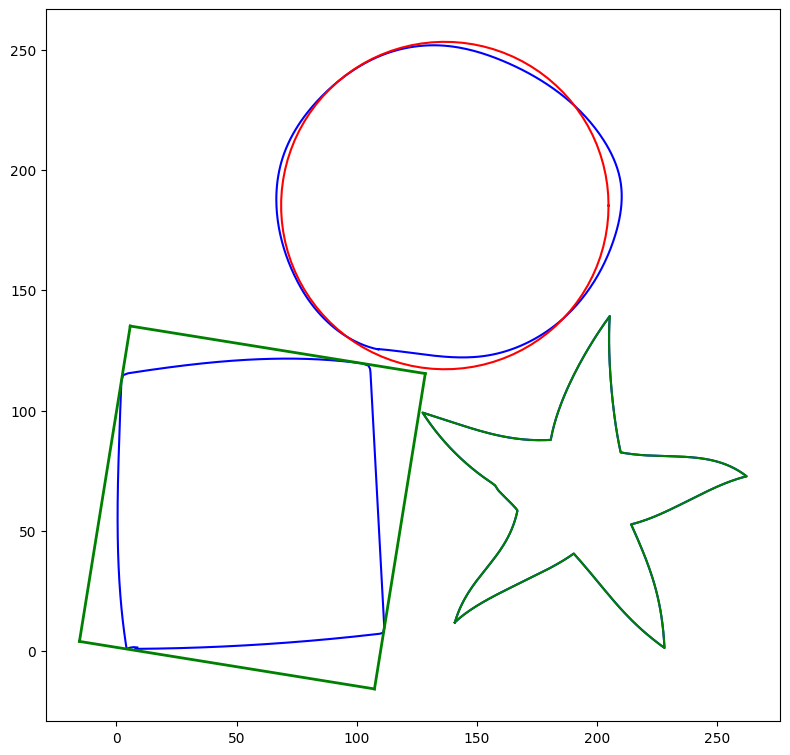

In [22]:
import matplotlib.pyplot as plt
def plot_shapes(path_XYs):
    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))
    colours = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    
    for i, shape in enumerate(path_XYs):
        for path in shape:
            ax.plot(path[:, 0], path[:, 1], 'b', label='Straight Line')

            if is_straight_line(path):
                print("hello_line")
                ax.plot(path[:, 0], path[:, 1], 'b', label='Straight Line')
            elif is_circle(path):
                print("hello_circle")
                ax.plot(*regularize_circle(path).T, 'r', label='Circle')
            
            elif is_rectangle(path,i):
                regularized_XY = regularize_rectangle(path)
                # Connect the corners to plot the rectangle
                for i in range(len(regularized_XY)):
                    ax.plot([regularized_XY[i][0], regularized_XY[(i + 1) % 4][0]], 
                            [regularized_XY[i][1], regularized_XY[(i + 1) % 4][1]], 
                            'g-', linewidth=2, label='Regularized Rectangle')
            elif is_ellipse(path):
                print("hello_ellipse")
                ax.plot(*regularize_ellipse(path).T, 'g', label='Ellipse')
            # elif is_regular_polygon(path):
            #     print("hello_polygon")
            #     ax.plot(*regularize_polygon(path).T, 'm', label='Polygon')
            # elif is_star_shape(path):
            #     print("hello_star")
            #     ax.plot(*regularize_star(path).T, 'y', label='Star')
    
    ax.set_aspect('equal')
    plt.show()

plot_shapes(path_XYs)
